# FINAL PROJECT 3 (ENSEMBLE)-PHYTON FOR DATA SCIENCE
1. Krisna Winar Setiawan - PYTN-KS14-016
2. Jaelani - PYTN-KS14-002

# Projects Overview
Data ini memiliki 13 atribut. Prediksi keselamatan pasien dari penyakit jantung.
# Attribute Information:
1. age - umur pasien
2. anaemia - apakah ada pengurangan haemoglobin
3. creatinine_phosphokinase - level enzim CPK dalam mcg/L
4. diabetes - apakah pasien punya riwayat diabetes
5. ejection_fraction - persentase darah yang meninggalkan jantung dalam persentasi
di setiap kontraksi jantung
6. high_blood_pressure - apakah pasien punya darah tinggi
7. platelets - jumlah platelet di darah dalam kiloplatelets/mL
8. serum_creatinine - level serum creatinine di darah dalam mg/dL
9. serum_sodium - level serum sodium di darah dalam mEq/L
10. sex - apakah pasien pria atau wanita
11. smoking - apakah pasien merokok
12. time - waktu dalam hari untuk follow-up
13. DEATH_EVENT - apakah pasien sudah meninggal saat waktu follow-up

# Random Forest
Random Forest secara teknis adalah ensemble method (berdasarkan pendekatan divide-and-conquer) dari decision trees yang dihasilkan pada dataset yang dipisahkan secara acak. Kumpulan decision tree classifiers ini juga dikenal sebagai forest. Decision trees individu dihasilkan menggunakan indikator pemilihan atribut seperti information gain, gain ratio, dan Gini index untuk setiap atribut. Setiap pohon bergantung pada sampel acak yang independen. Dalam masalah klasifikasi, setiap pohon memilih dan kelas paling populer dipilih sebagai hasil akhir. Dalam kasus regresi, rata-rata dari semua keluaran pohon dianggap sebagai hasil akhir. Ini lebih sederhana dan lebih kuat dibandingkan dengan algoritma klasifikasi non-linier lainnya.

## Random forest bekerja dalam 4 tahap:

1. Pilih sampel acak dari kumpulan data yang diberikan.
2. Buat decision tree untuk setiap sampel dan dapatkan hasil prediksi dari setiap decision tree.
3. Lakukan voting untuk setiap hasil prediksi.
4. Pilih hasil prediksi dengan suara terbanyak sebagai prediksi akhir.

# IMPORT LIBRARY

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns

# Modeling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

# PREPARING DATA 

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d andrewmvd/heart-failure-clinical-data

  0% 0.00/3.97k [00:00<?, ?B/s]
100% 3.97k/3.97k [00:00<00:00, 11.8MB/s]


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/heart-failure-clinical-data.zip', 'r')
zip_file.extractall('/tmp/')

# LOAD DATA

In [ ]:
# Load dataset using python pandas and display top 5 data
df = pd.read_csv('/tmp/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


df berisi informasi mengenai orang seperti Age, anaemia, creatinine, diabetes etc which are features and DEATH_EVENT

In [ ]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from numeric features
outliers_to_drop = detect_outliers(df, 2 ,["age","anaemia","creatinine_phosphokinase","platelets", "serum_creatinine", "serum_sodium", "time"])

code diatas menggunakan metode Tukey. Metode Tukey adalah prosedur perbandingan berganda satu langkah dan uji statistik. Ini dapat digunakan untuk menemukan solusi yang berbeda secara signifikan satu sama lain. Saya melihat outlier dalam fitur numerik (usia, anemia, kreatinin fosfokinase, dll.). Saya kemudian menganggap outlier sebagai baris dengan setidaknya dua nilai berbeda.

# Check Data and Explore Data

In [ ]:
df.loc[outliers_to_drop] # Show the outliers rows

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


Tidak ada fitur yang mengandung lebih dari 2 outlier

In [ ]:
# Find columns with null values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Df tidak memiliki missing value

In [ ]:
# Infos
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

<Axes: >

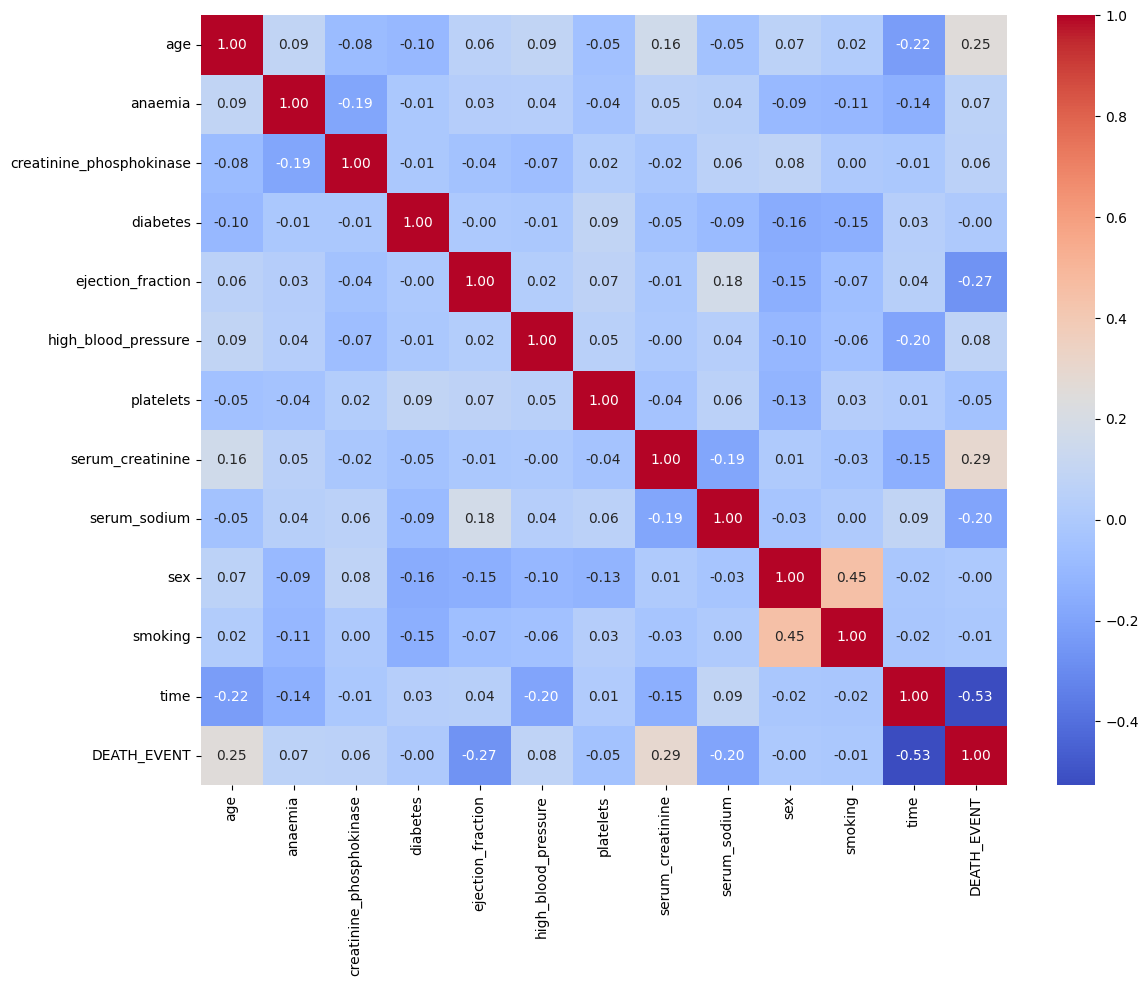

In [ ]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

age dan serum_creatinine tampaknya memiliki korelasi yang signifikan dengan probabilitas death event. ejection_fraction dan serum_sodium juga berkorelasi negatif dengan death event

Ini tidak berarti bahwa fitur lain tidak berguna. Kita perlu mengeksplorasi secara detail fitur-fitur ini untuk menentukan korelasinya

<ipython-input-15-2620ea304175>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 1], color="Red", shade = True)
<ipython-input-15-2620ea304175>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 0], ax =g, color="Blue", shade= True)


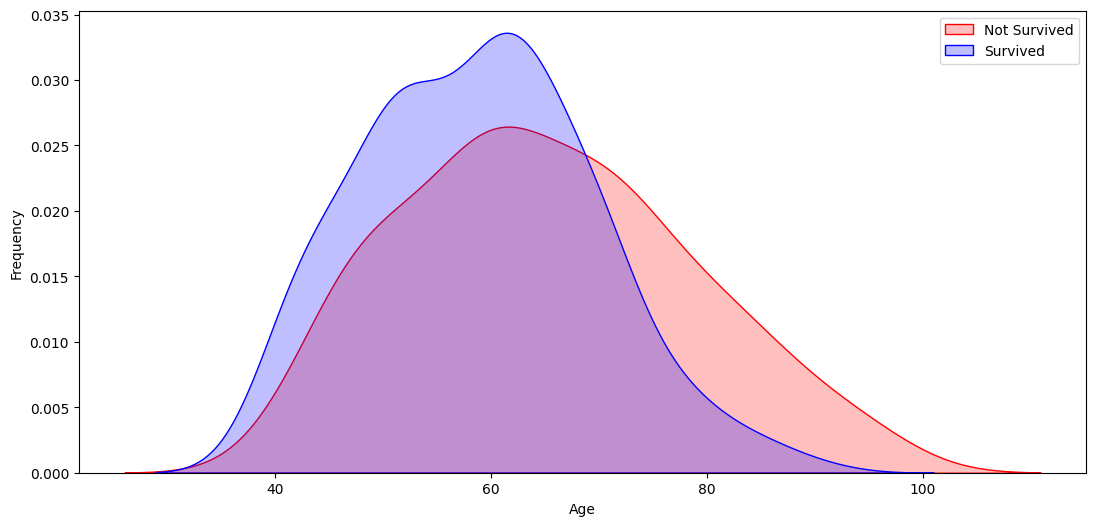

In [ ]:
# Explore Age vs DEATH_EVENT
plt.figure(figsize=(13,6))
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 1], color="Red", shade = True)
g = sns.kdeplot(df["age"][df["DEATH_EVENT"] == 0], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived","Survived"])

<ipython-input-16-74bb3eed2f16>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(df["creatinine_phosphokinase"], color="m", label="Skewness : %.2f"%(df["creatinine_phosphokinase"].skew()))


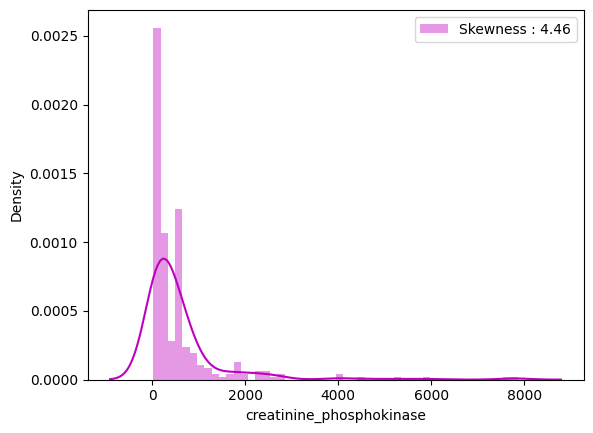

In [ ]:
# Explore Fare distribution 
g = sns.distplot(df["creatinine_phosphokinase"], color="m", label="Skewness : %.2f"%(df["creatinine_phosphokinase"].skew()))
g = g.legend(loc="best")

dari hasil distplot diatas kita dapatkan creatine phosphokinase terdistribusi sangat tidak merata. Hal ini dapat menyebabkan kelebihan berat pada nilai model yang sangat tinggi, bahkan saat diskalakan.

Dalam hal ini, lebih baik mengubahnya dengan fungsi log untuk mengurangi skewness

In [ ]:
# Apply log to Fare to reduce skewness distribution
df["creatinine_phosphokinase"] = df["creatinine_phosphokinase"].map(lambda i: np.log(i) if i > 0 else 0)

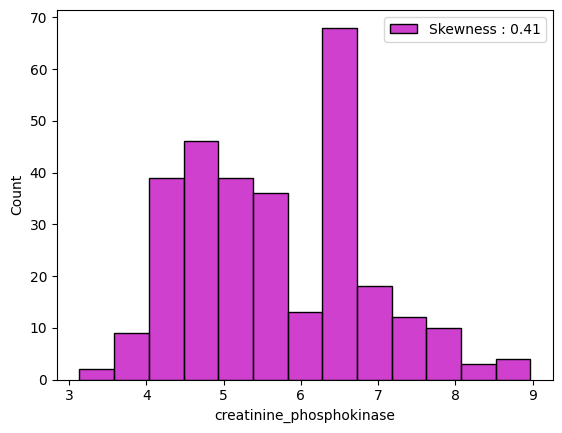

In [ ]:
g = sns.histplot(df["creatinine_phosphokinase"], color="m", label="Skewness : %.2f"%(df["creatinine_phosphokinase"].skew()))
g = g.legend(loc="best")

Skewness jelas berkurang setelah transformasi log

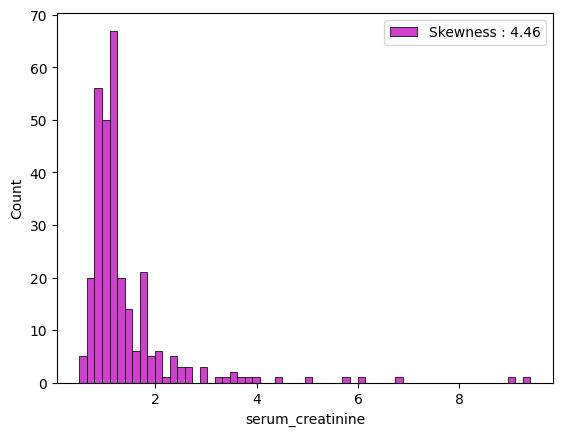

In [ ]:
# Explore Fare distribution 
g = sns.histplot(df["serum_creatinine"], color="m", label="Skewness : %.2f"%(df["serum_creatinine"].skew()))
g = g.legend(loc="best")

### Anaemia and Death Event

Text(0, 0.5, 'Survival Probability')

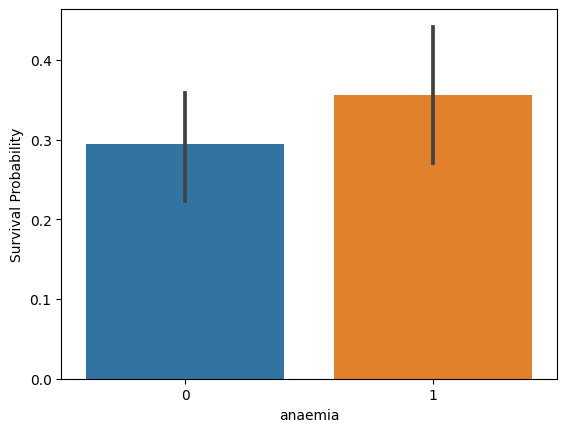

In [ ]:
g = sns.barplot(x="anaemia",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

### Sex and Death Event

Text(0, 0.5, 'Survival Probability')

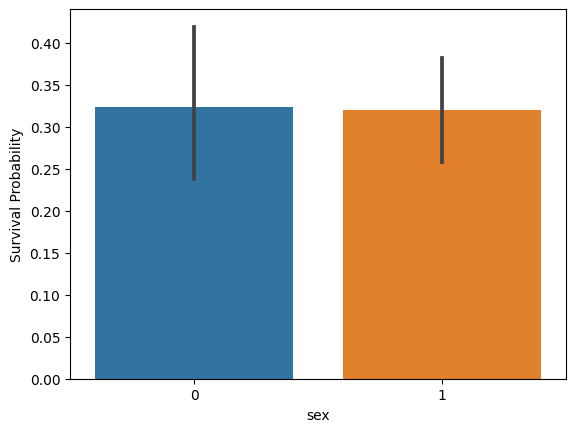

In [ ]:
g = sns.barplot(x="sex",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

In [ ]:
df[["sex","DEATH_EVENT"]].groupby('sex').mean()

,DEATH_EVENT
sex,
0,0.323810
1,0.319588


Jenis kelamin pasien Laki-laki = 1, Perempuan = 0

Menurut hasil diatas , laki-laki dan perempuan sama-sama memiliki peluang bertahan hidup yang sama. Jadi Jenis Kelamin, mungkin tidak memainkan peran penting dalam prediksi kematian.

### Diabetes and Death Event

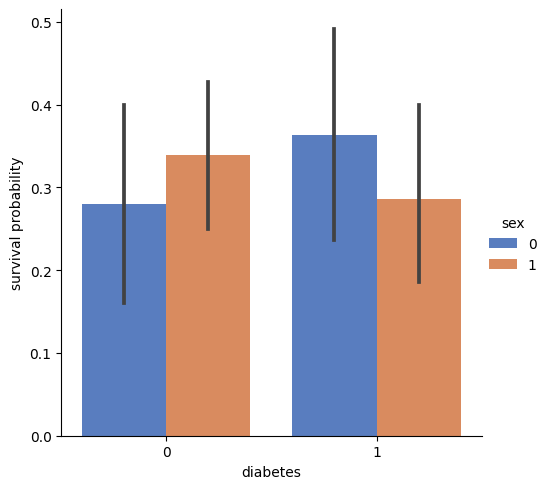

In [ ]:
# Explore diabetes vs Survived by Sex
g = sns.catplot(x="diabetes", y="DEATH_EVENT", hue="sex", data=df,
                   kind="bar", palette="muted")
g.set_ylabels("survival probability")

Menurut hasil diatas wanita dengan diabetes memiliki lebih banyak kemungkinan mengalami gagal jantung

### High Blood Pressure and Death Event

Text(0, 0.5, 'Survival Probability')

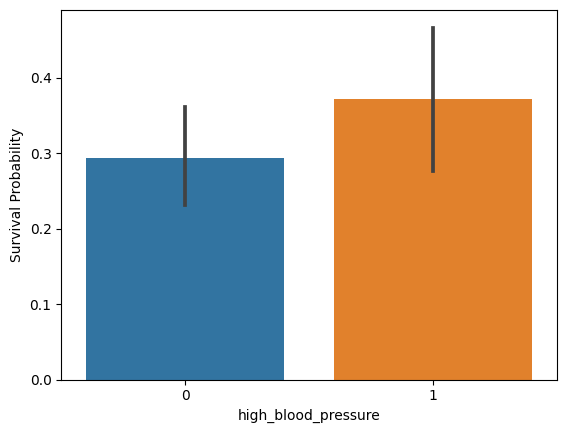

In [ ]:
g = sns.barplot(x="high_blood_pressure",y="DEATH_EVENT",data=df)
g.set_ylabel("Survival Probability")

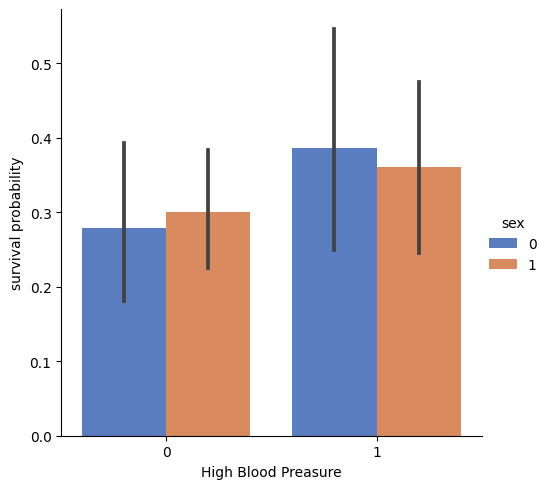

In [ ]:
# Explore diabetes vs Survived by Sex
g = sns.catplot(x="high_blood_pressure", y="DEATH_EVENT", hue="sex", data=df,
                    kind="bar", palette="muted")
g.set_ylabels("survival probability")
g.set_xlabels("High Blood Preasure")

Dari hasil diatas wanita dengan diabetes memiliki lebih banyak kemungkinan gagal jantung

### Death Event and Serum Sodium/Smoking

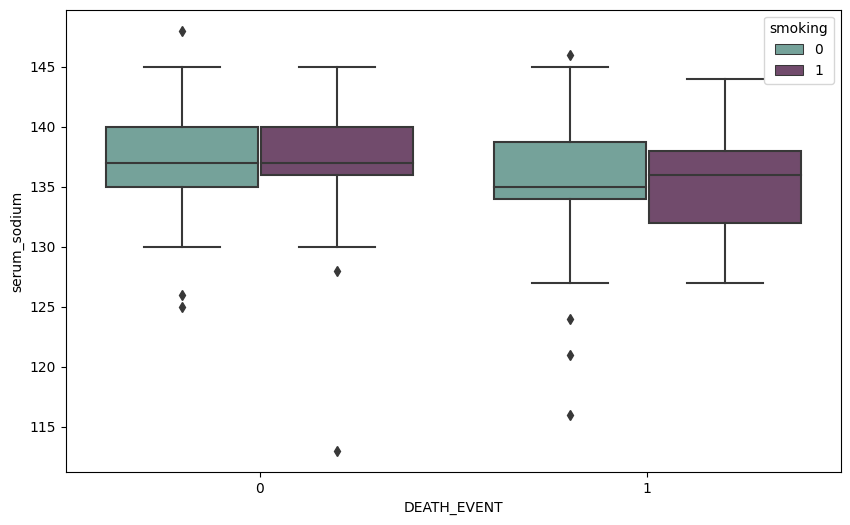

In [ ]:
# Explore Serum Sodium vs Death Event vs Smoking

plt.figure(figsize=(10,6))
sns.boxplot(x=df["DEATH_EVENT"], y=df['serum_sodium'], hue=df['smoking'], palette=["#6daa9f","#774571"])
plt.show()

### Death Event and Platelets and anaemia

<Axes: xlabel='DEATH_EVENT', ylabel='platelets'>

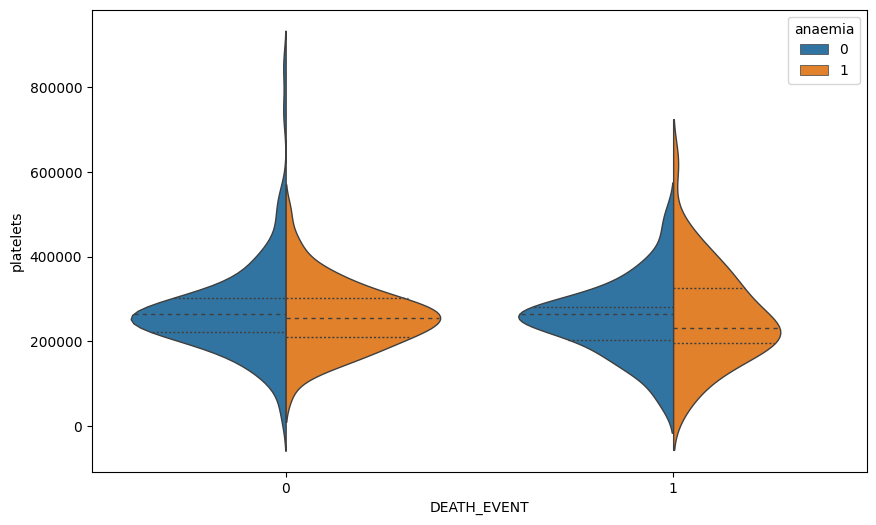

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="DEATH_EVENT", y="platelets", hue="anaemia",
               split=True, inner="quart", linewidth=1,
               )

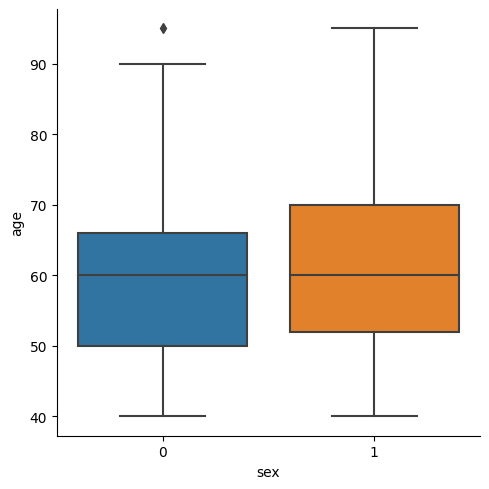

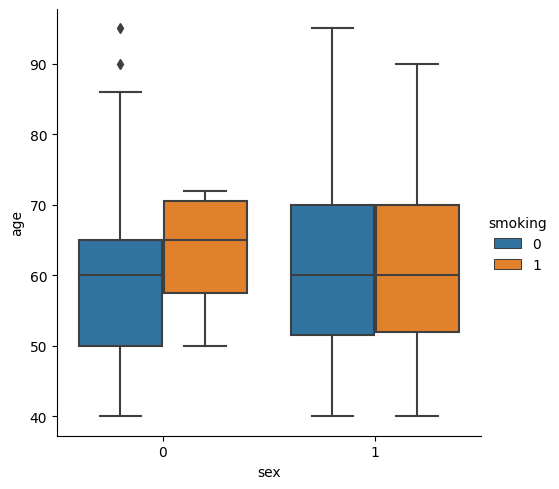

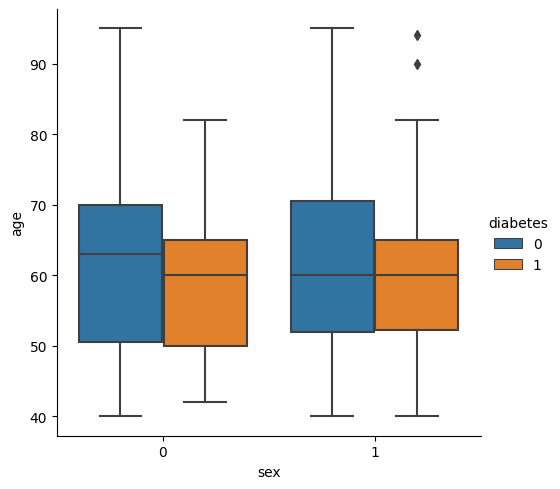

In [ ]:
# Explore Age vs Sex, Parch , Pclass and SibSP
sns.catplot(y="age",x="sex",data=df,kind="box")
sns.catplot(y="age",x="sex",hue="smoking", data=df,kind="box")
sns.catplot(y="age",x="sex",hue="diabetes", data=df,kind="box")

### Create Categorical Values

In [ ]:
df = pd.get_dummies(df, columns = ["anaemia"], prefix="ena")
df = pd.get_dummies(df, columns = ["diabetes"], prefix="dia")
df = pd.get_dummies(df, columns = ["high_blood_pressure"], prefix="hbp")
df = pd.get_dummies(df, columns = ["sex"], prefix="sex")
df = pd.get_dummies(df, columns = ["smoking"], prefix="smk")

In [ ]:
df.time.value_counts()

250    7
187    7
10     6
186    6
107    6
      ..
97     1
96     1
86     1
77     1
285    1
Name: time, Length: 148, dtype: int64

### Data Splitting

In [ ]:
## Separate train dataset and test dataset
features = df.drop(["DEATH_EVENT"], axis=1)
labels = df["DEATH_EVENT"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

### Cross Validate Models
Disini saya menggunakan  7 model klasifikasi paling populer dan mengevaluasi akurasi rata-rata dengan prosedur validasi kfold cross

1. Logistic regression
2. Decision Tree
3. AdaBoost
4. SVC
5. Random Forest
6. Gradient Boosting
7. KNN

In [ ]:
def evaluate_model(models):
    
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        result.append(cross_val_score(model, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "KNeighborsClassifier"
        ]
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

,CrossValMeans,CrossValerrors,Models
0,0.794762,0.089909,LogisticRegression
1,0.760238,0.046438,DecisionTreeClassifier
2,0.784524,0.044686,AdaBoostClassifier
3,0.660238,0.014602,SVC
4,0.799048,0.073086,RandomForestClassifier
5,0.798571,0.077899,GradientBoostingClassifier
6,0.660714,0.067185,KNeighborsClassifier


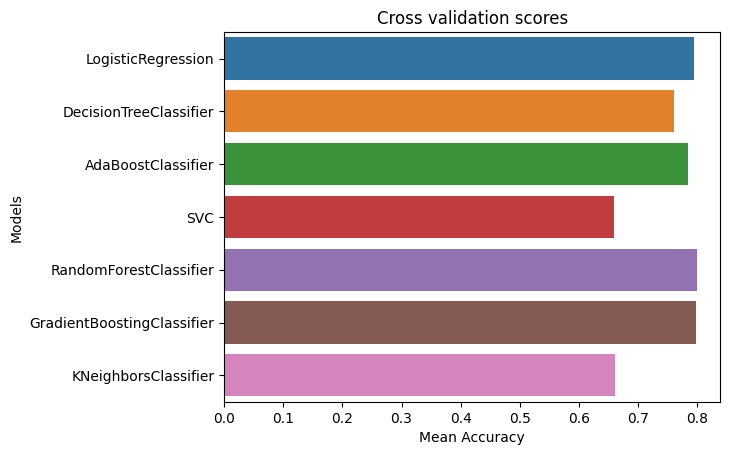

In [ ]:
# Modeling step Test differents algorithms 
random_state = 30
models = [
    LogisticRegression(random_state = random_state),
    DecisionTreeClassifier(random_state = random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.2),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    KNeighborsClassifier(),
]
evaluate_model(models)

# KESIMPULAN
Berdasarkan skor validasidiatas ,pengklasifikasian yang mungkin digunakan  LogisticRegression, RandomForest, GradientBoosting , dan DecisionTree untuk ensemble modeling